### Installing Ultralytics Yolo package

In [1]:
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.3 MB/s eta 0:00:00


### Patrick + Copy-Paste Augmentation

In [ ]:
import cv2
import random
import numpy as np
from tqdm import tqdm
from pathlib import Path

def load_segment(path):
    image = cv2.imread(str(path))
    if image is None:
        raise FileNotFoundError(f"Image not found: {path}")

    H, W, _ = image.shape
    label_file = path.parent.parent / "labels" / f"{path.stem}.txt"
    with open(label_file, "r") as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) > 5:
                points = np.array(parts[1:], dtype=float).reshape(-1, 2)
                return image, (points * [W, H]).astype(int)

    raise ValueError(f"Segment not found in: {label_file}")

def resize_foreground(args, flip=True):
    image, segment = args
    H, W, _ = image.shape
    mask = np.zeros((H, W), dtype=np.uint8)
    cv2.fillPoly(mask, [segment], 255)

    # Random horizontal flip
    if flip and random.random() < 0.5:
        image = cv2.flip(image, 1)
        mask = cv2.flip(mask, 1)

    # Random scaling
    w, h = np.ptp(segment, axis=0)
    scale = random.uniform(0.8, min(W / w, H / h, 1.2))
    image = cv2.resize(image, None, fx=scale, fy=scale)
    mask = cv2.resize(mask, None, fx=scale, fy=scale)
    _, mask = cv2.threshold(mask, 250, 255, cv2.THRESH_BINARY)

    # Crop to bounding box
    x, y, w, h = cv2.boundingRect(mask)
    return image[y:y+h, x:x+w], mask[y:y+h, x:x+w]

def resize_background(args, flip=True):
    image, segment = args
    H, W, _ = image.shape
    canvas = np.zeros_like(image)

    # Random scaling
    scale = random.uniform(0.8, 1.2)
    image = cv2.resize(image, None, fx=scale, fy=scale)
    h, w, _ = image.shape
    x1, y1 = (np.min(segment, axis=0) * scale).astype(int)
    x2, y2 = (np.max(segment, axis=0) * scale).astype(int)

    # Random horizontal flip
    if flip and random.random() < 0.5:
        image = cv2.flip(image, 1)
        x1, x2 = w - x2, w - x1

    # Paste onto a blank canvas
    canvas[:min(H, h), :min(W, w)] = image[:min(H, h), :min(W, w)]

    if x1 < W and y1 < H:
        return canvas, np.array([[x1, y1], [min(x2, W), min(y2, H)]])
    return canvas, None

def load_patrick(path="patrick.png", shape="default"):
    if shape == "square":
        return np.full((100, 100, 3), 255, dtype=np.uint8), np.full((100, 100), 255, dtype=np.uint8)
    if shape == "sphere":
        mask = np.zeros((100, 100), dtype=np.uint8)
        cv2.circle(mask, (50, 50), 50, 255, -1)
        return np.full((100, 100, 3), 255, dtype=np.uint8), mask

    # Load image and alpha mask
    b, g, r, a = cv2.split(cv2.imread(path, cv2.IMREAD_UNCHANGED))
    image = cv2.merge((b, g, r))
    _, mask = cv2.threshold(a, 128, 255, cv2.THRESH_BINARY)

    # Crop to bounding box
    x, y, w, h = cv2.boundingRect(a)
    return image[y:y+h, x:x+w], mask[y:y+h, x:x+w]

def augment_patrick(image, mask, max_size):
    # Random hue and saturation
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv[..., 0] = random.randint(0, 179)
    hsv[..., 1] = random.randint(0, 255)
    image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    # Random scaling
    h, w, _ = image.shape
    fx = random.uniform(0.5, 1.0) * max_size[0] / w
    fy = random.uniform(0.5, 1.0) * max_size[1] / h
    image = cv2.resize(image, None, fx=fx, fy=fy)
    mask = cv2.resize(mask, None, fx=fx, fy=fy)

    # Random horizontal flip
    if random.random() < 0.5:
        image = cv2.flip(image, 1)
        mask = cv2.flip(mask, 1)

    return image, mask

def imprint_augmented_patrick(background, image, mask, box, nums=5):
    if box is None:
        return

    H, W, _ = background.shape
    center = (box[0] + box[1]) / 2
    spread = (box[1] - box[0])

    for _ in range(nums):
        aug_image, aug_mask = augment_patrick(image, mask, box[1] - box[0])
        h, w, _ = aug_image.shape

        # Sample position using Gaussian spread
        dx = int(np.clip(random.gauss(center[0], spread[0]) - w / 2, 0, W - w))
        dy = int(np.clip(random.gauss(center[1], spread[1]) - h / 2, 0, H - h))

        roi = background[dy:dy+h, dx:dx+w]
        bg_part = cv2.bitwise_and(roi, roi, mask=cv2.bitwise_not(aug_mask))
        fg_part = cv2.bitwise_and(aug_image, aug_image, mask=aug_mask)
        background[dy:dy+h, dx:dx+w] = cv2.add(bg_part, fg_part)

def save_label(file, box):
    x, y = (box[0] + box[1]) / 2
    w, h = box[1] - box[0]
    file.write(f"0 {x} {y} {w} {h}\n")

def cut_paste_patrick(source="/LeBron/train", nums=1, save=False):
    source_path = Path(source)
    images = list((source_path / "images").glob("*.jpg"))

    for i in tqdm(range(nums)):
        try:
            bg_path, fg_path = random.choices(images, k=2)

            # Load and resize background and foreground
            background, bg_box = resize_background(load_segment(bg_path))
            foreground, fg_mask = resize_foreground(load_segment(fg_path))
            patrick_img, patrick_mask = load_patrick()

            H, W, _ = background.shape
            h, w, _ = foreground.shape
            dx, dy = random.randint(0, W - w), random.randint(0, H - h)
            fg_box = np.array([[dx, dy], [dx + w, dy + h]])

            # Paste foreground onto background
            roi = background[dy:dy+h, dx:dx+w]
            masked_bg = cv2.bitwise_and(roi, roi, mask=cv2.bitwise_not(fg_mask))
            masked_fg = cv2.bitwise_and(foreground, foreground, mask=fg_mask)
            background[dy:dy+h, dx:dx+w] = cv2.add(masked_bg, masked_fg)

            # Overlay Patrick icons
            imprint_augmented_patrick(background, patrick_img, patrick_mask, bg_box)
            imprint_augmented_patrick(background, patrick_img, patrick_mask, fg_box)

            if save:
                output_image_path = source_path / "images" / f"{i}.jpg"
                output_label_path = source_path / "labels" / f"{i}.txt"
                cv2.imwrite(str(output_image_path), background)
                with open(output_label_path, "w") as label_file:
                    if bg_box is not None:
                        save_label(label_file, bg_box / [W, H])
                    save_label(label_file, fg_box / [W, H])
            else:
                # Preview mode
                cv2.rectangle(background, fg_box[0], fg_box[1], (255, 255, 0), 2)
                if bg_box is not None:
                    cv2.rectangle(background, bg_box[0], bg_box[1], (255, 255, 0), 2)
                resized = cv2.resize(background, (640, 360))
                cv2.imshow("Preview", resized)
                cv2.waitKey(0)
                cv2.destroyAllWindows()

        except Exception as error:
            print(f"Error processing image {i}: {error}")

  0%|          | 0/1 [00:00<?, ?it/s]

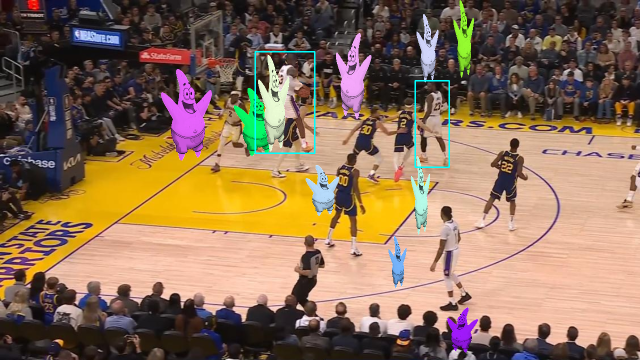

100%|██████████| 1/1 [00:00<00:00,  6.55it/s]


In [ ]:
# Example usage
cut_paste_patrick()

In [ ]:
# Main execution
cut_paste_patrick(nums=1000, save=True)

100%|██████████| 1000/1000 [01:13<00:00, 13.68it/s]


### Fine-tuning YOLO with Augmented Dataset

In [ ]:
!yolo task=detect mode=train model=yolo11n.pt data=/content/LeBron/data.yaml epochs=50 imgsz=1280 plots=True

In [ ]:
!yolo task=detect mode=val model=/content/runs/detect/train/weights/best.pt data=/content/Playoffs/data.yaml max_det=1 imgsz=1280 plots=True

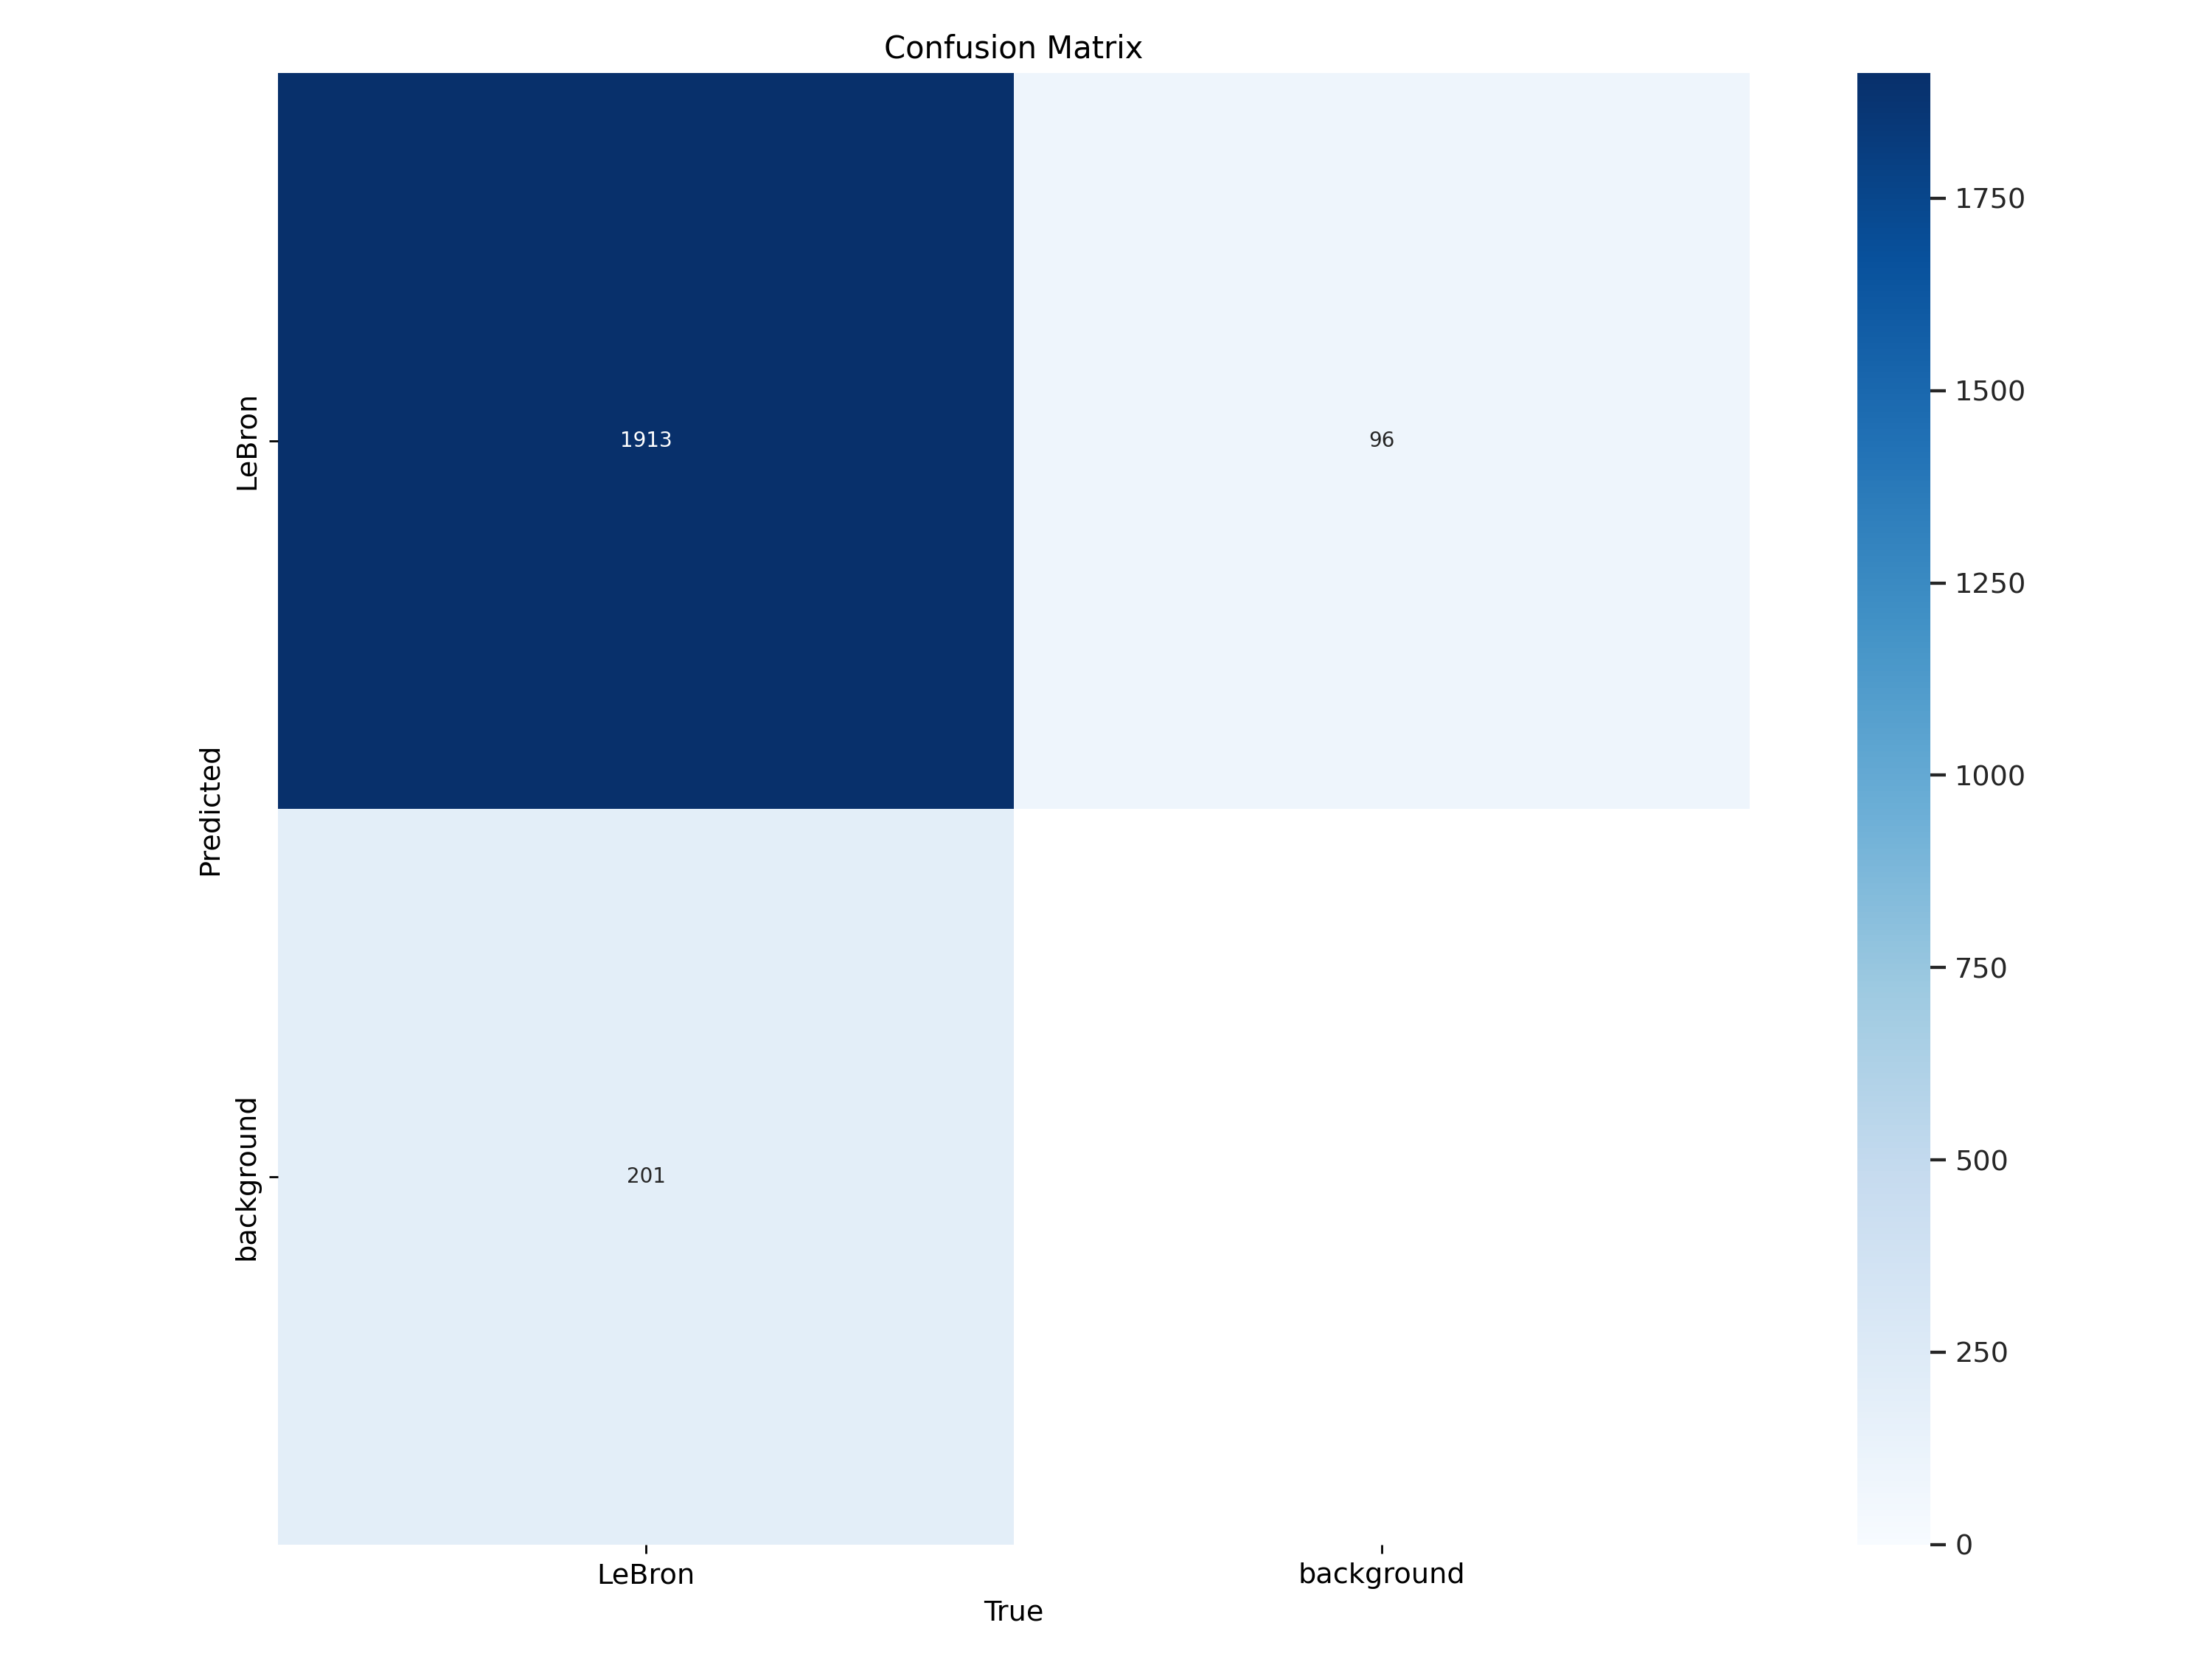

In [ ]:
from IPython.display import Image

Image(filename="/runs/detect/val/confusion_matrix.png")

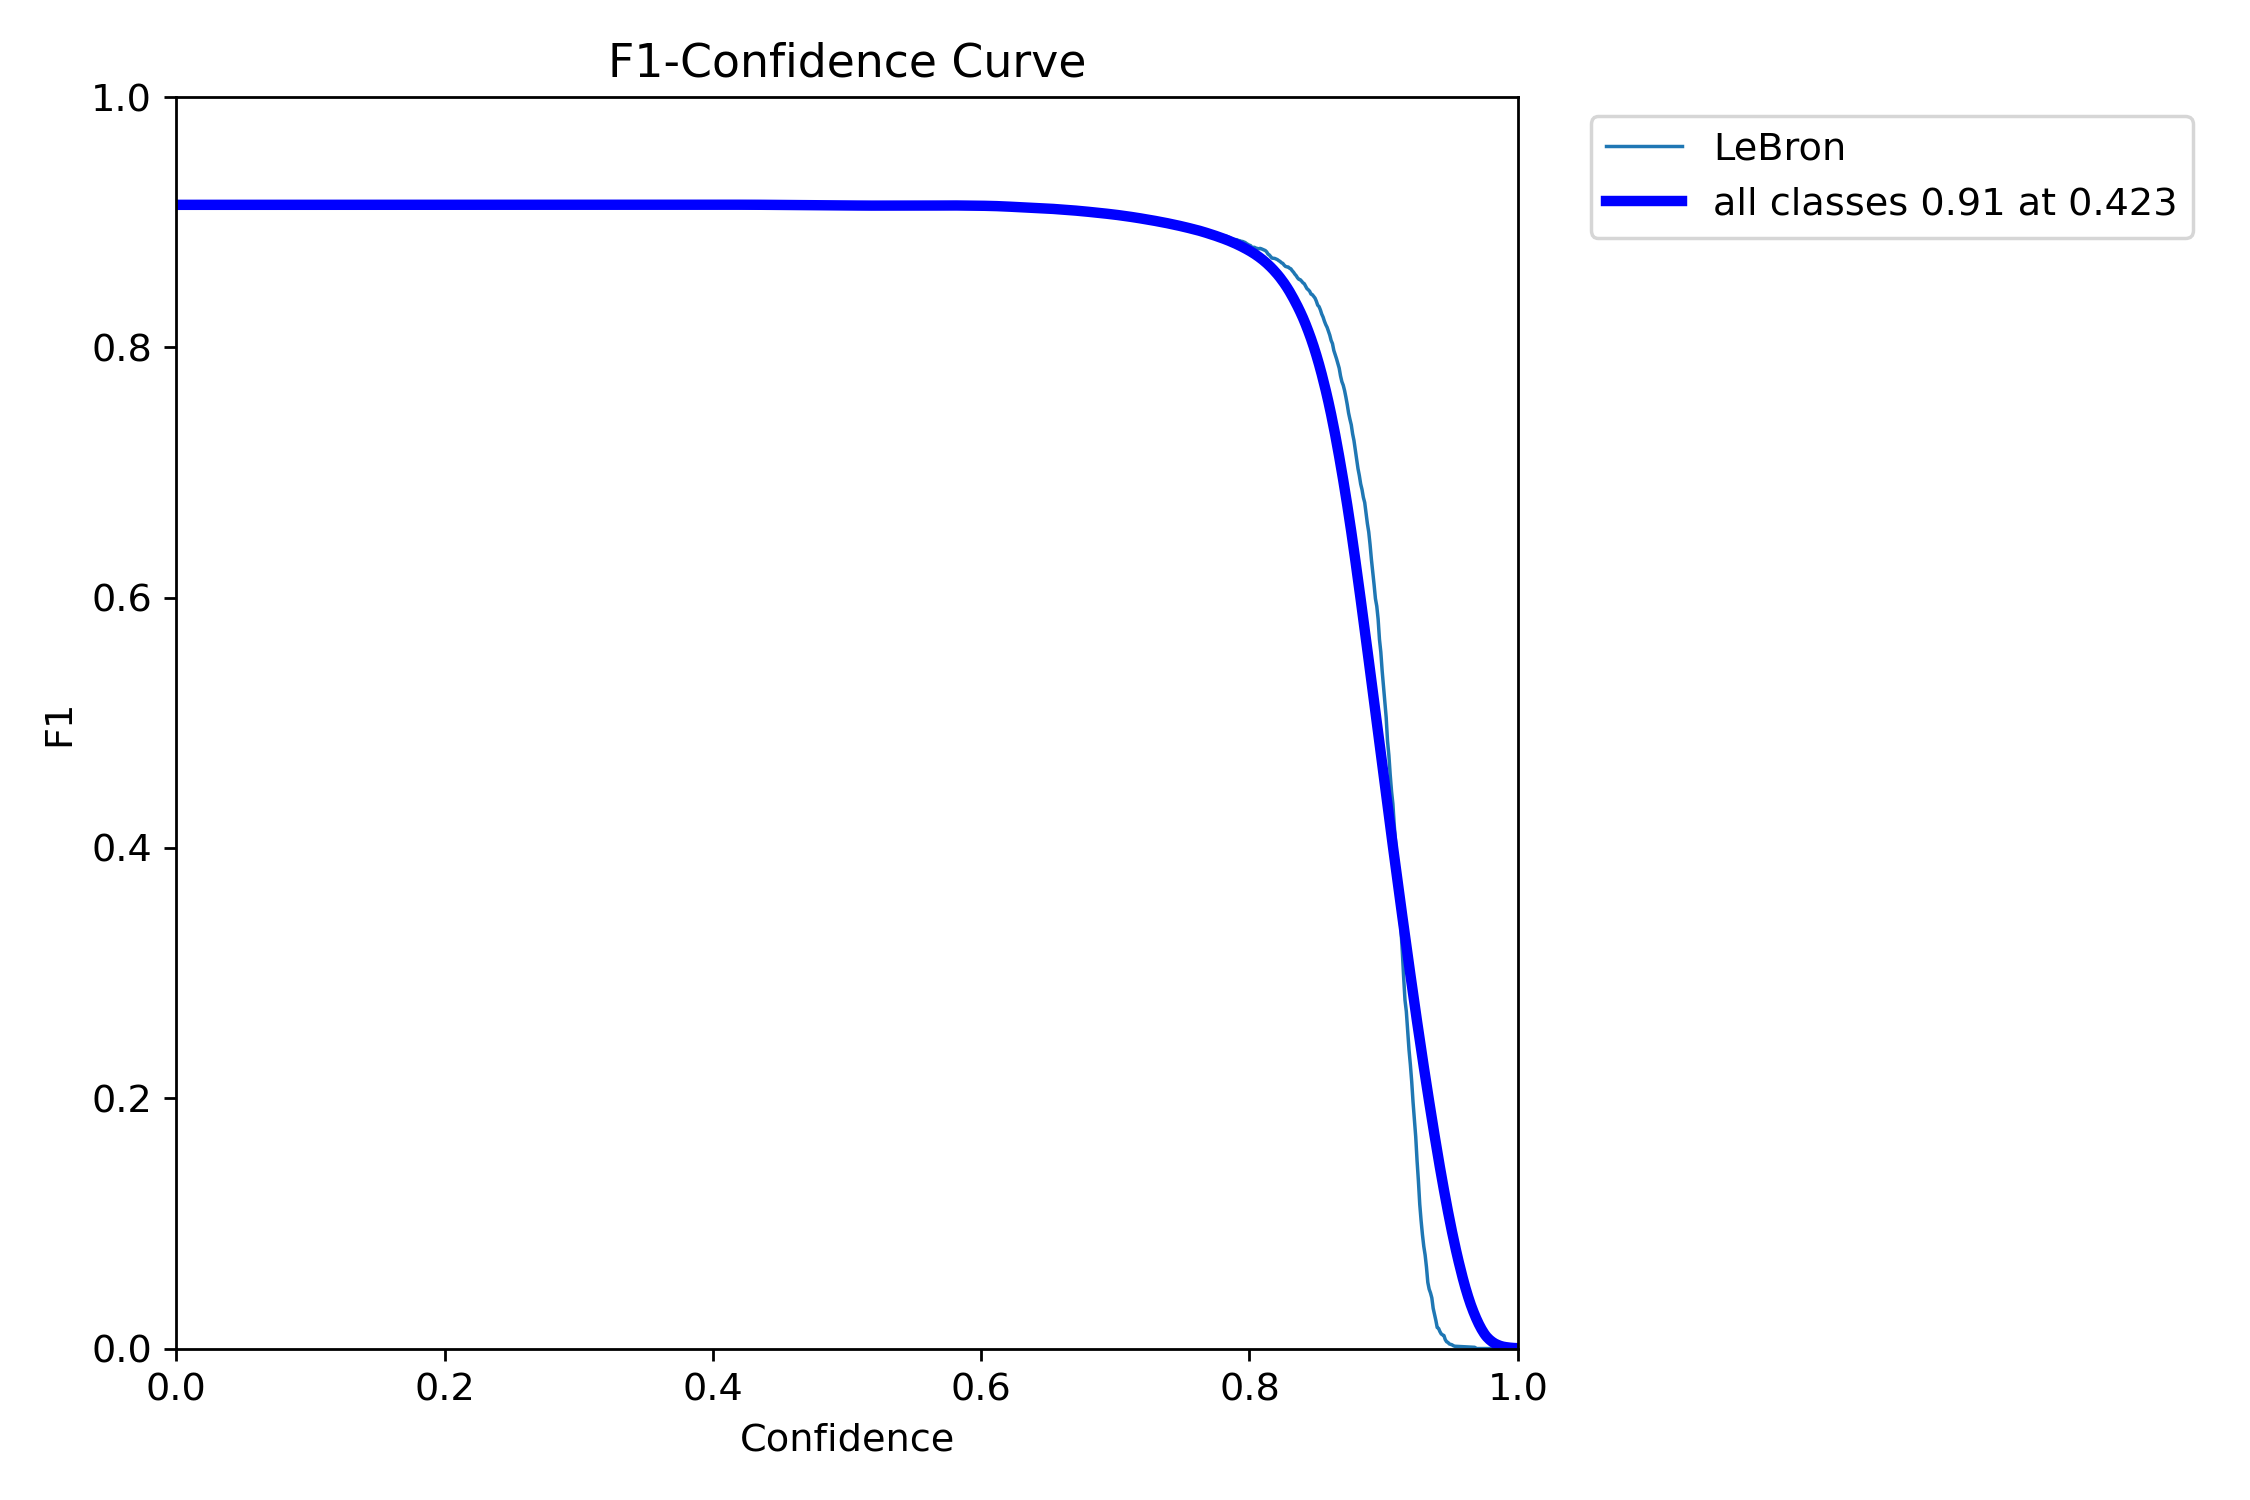

In [ ]:
Image(filename="/runs/detect/val/F1_curve.png")

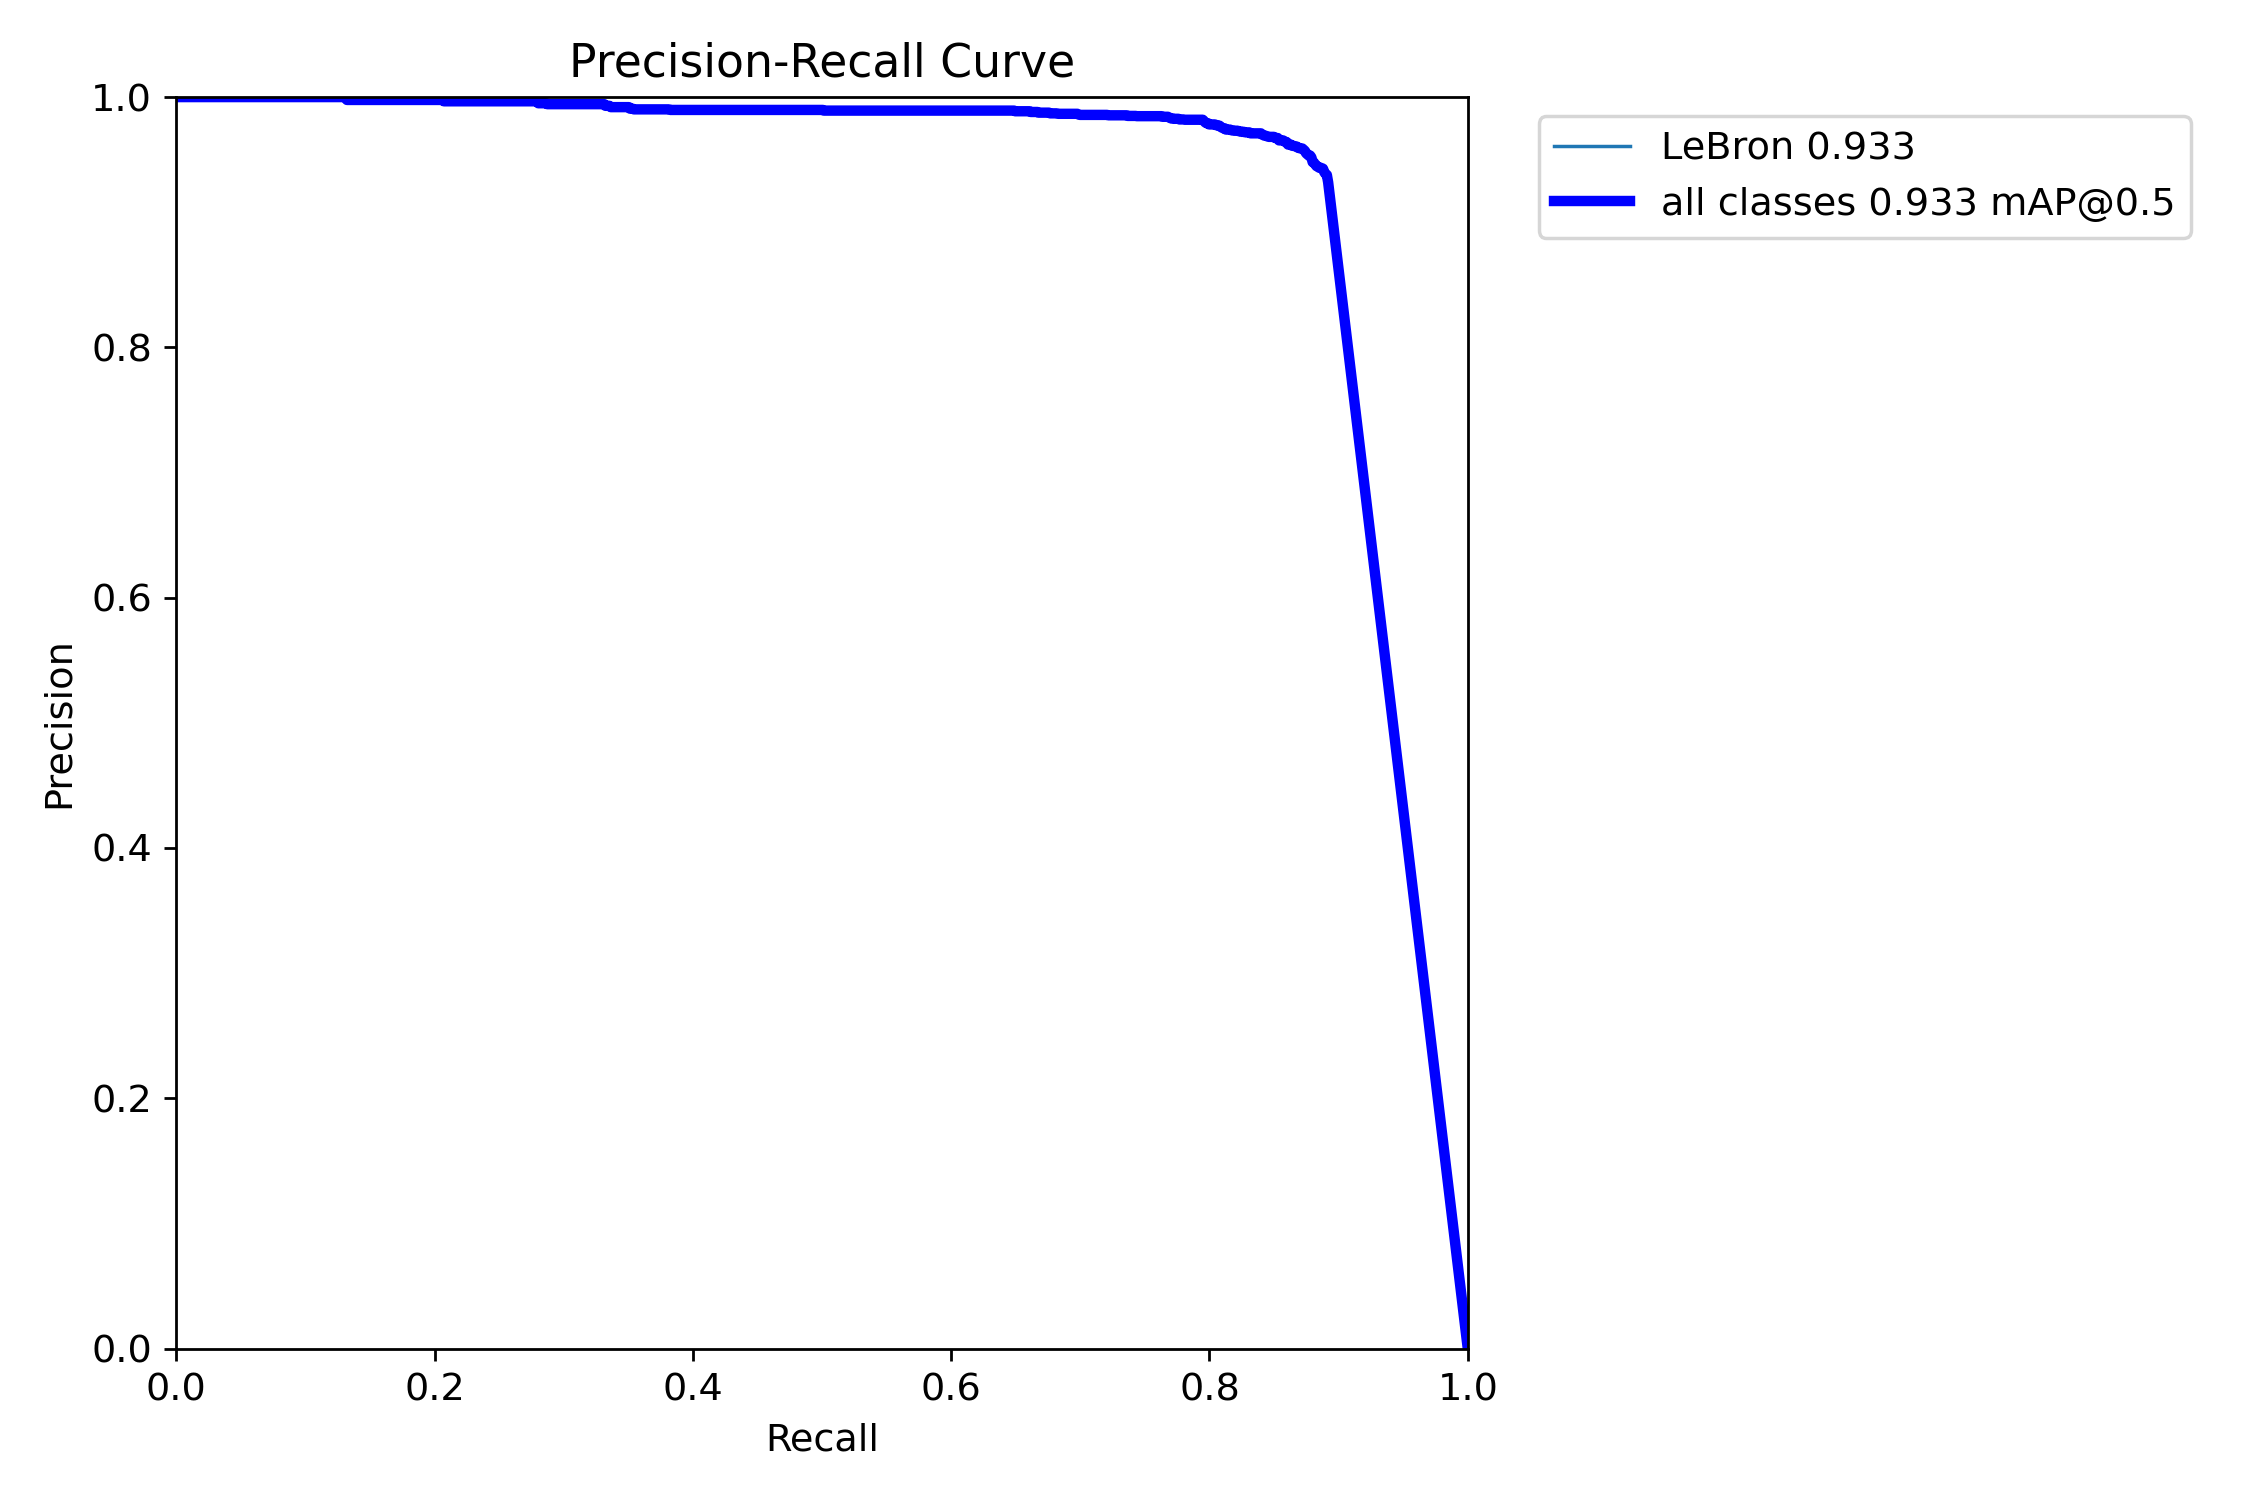

In [ ]:
Image(filename="/runs/detect/val/PR_curve.png")

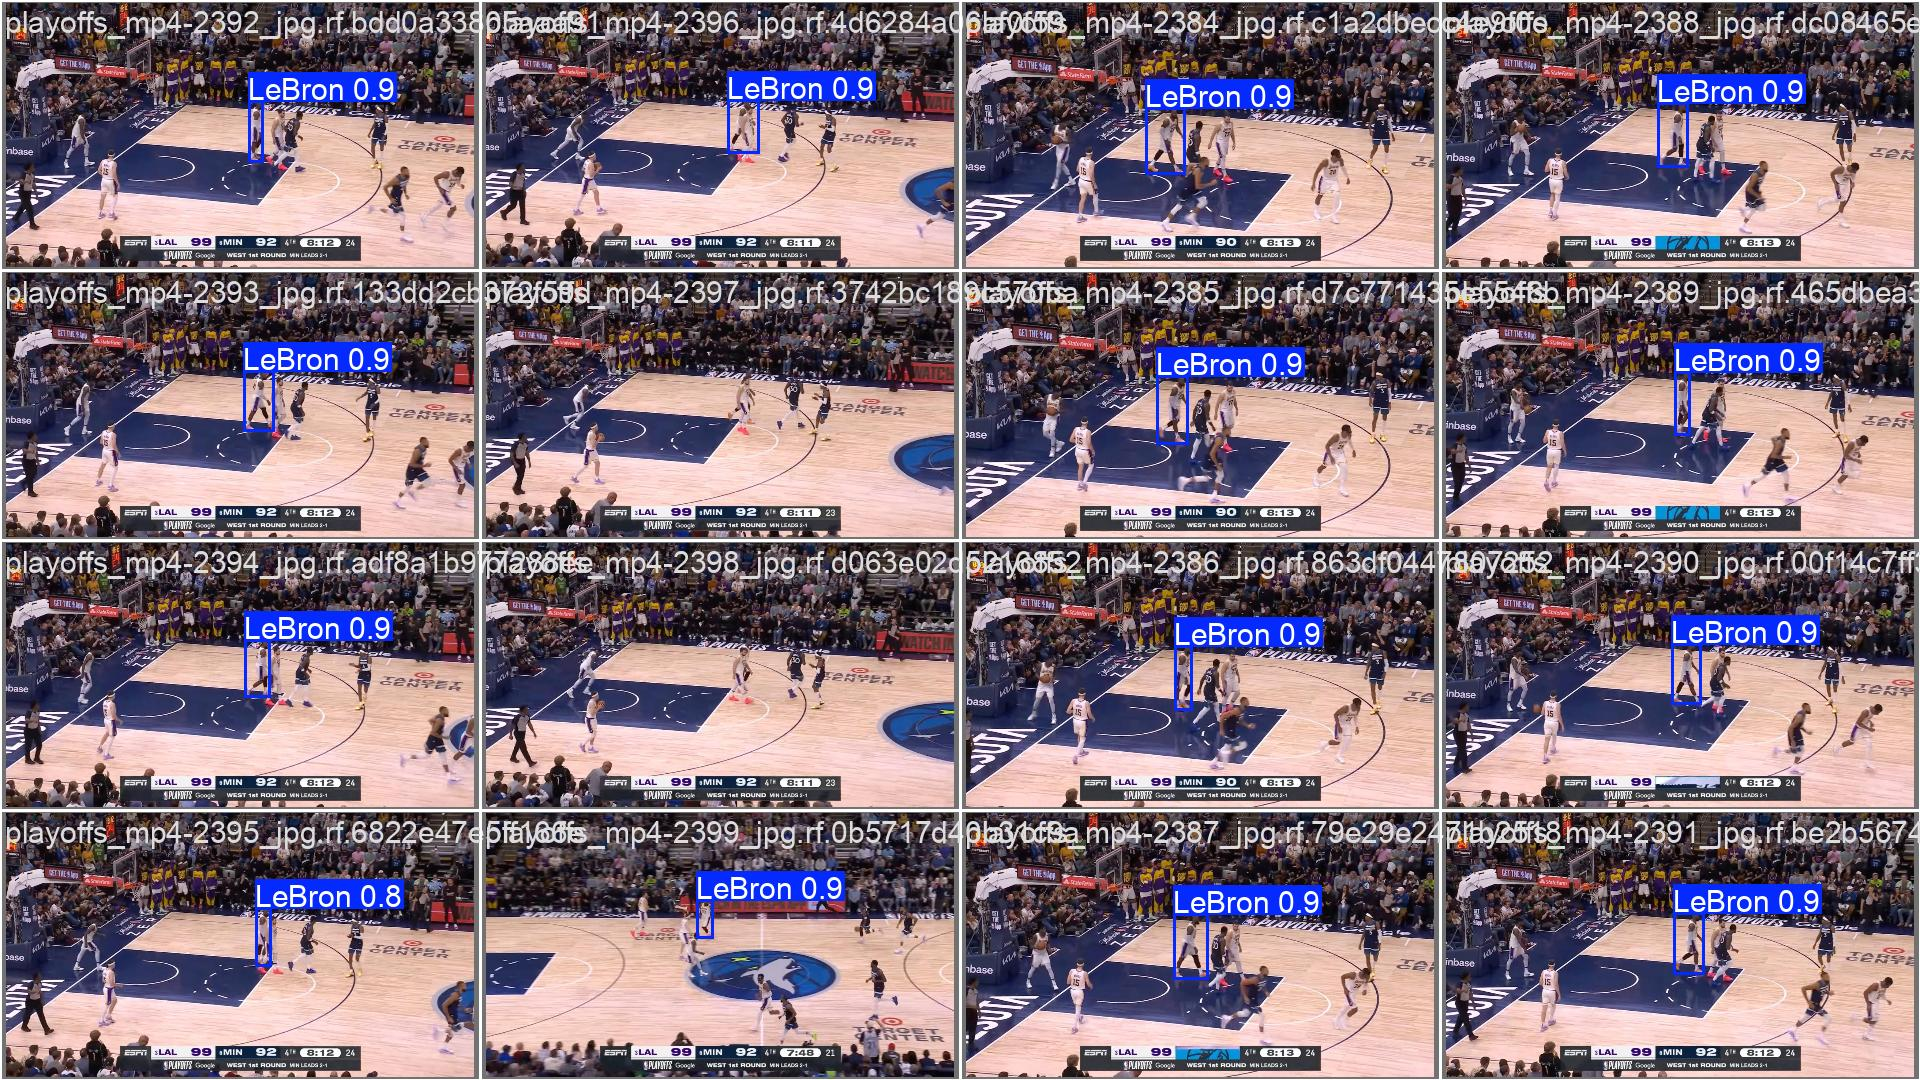

In [ ]:
Image(filename="/runs/detect/val/val_batch0_pred.jpg")

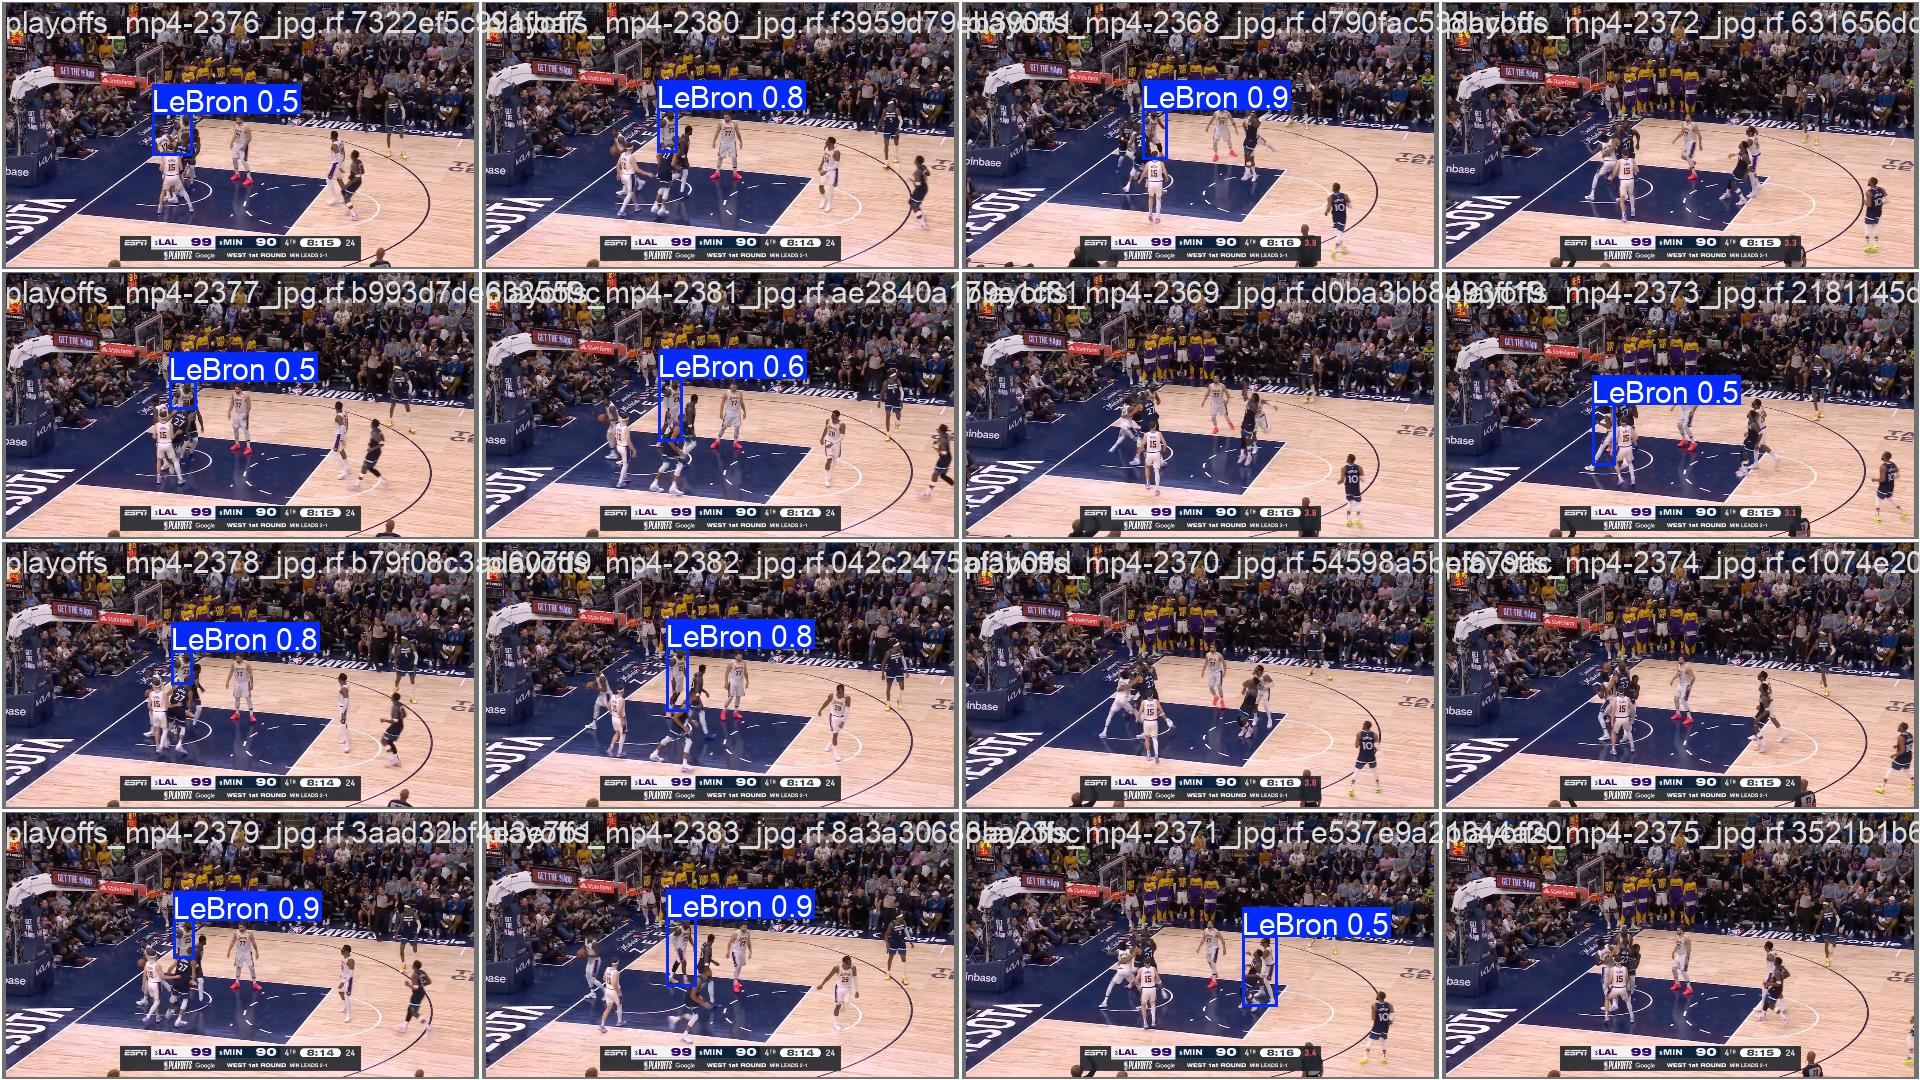

In [ ]:
Image(filename="/runs/detect/val/val_batch1_pred.jpg")

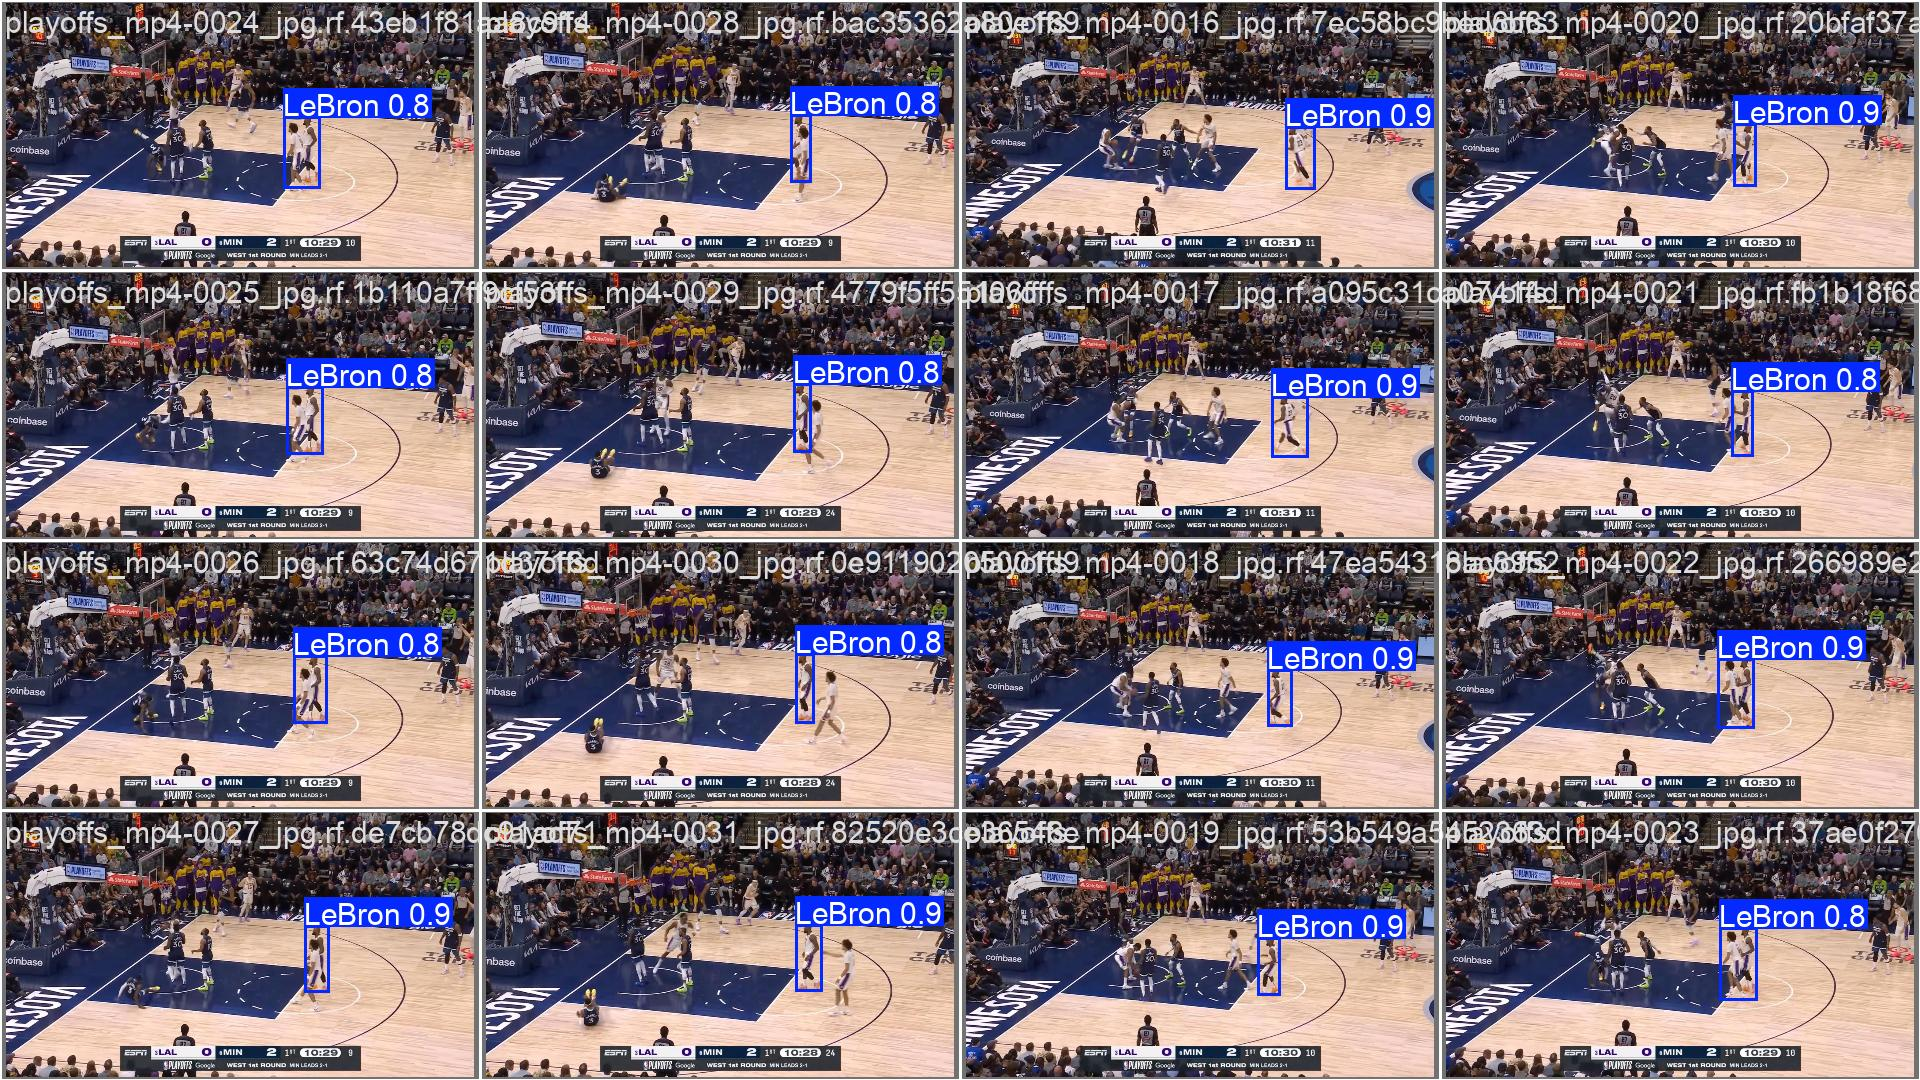

In [ ]:
Image(filename="/runs/detect/val/val_batch2_pred.jpg")